<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#2.1-Equal-Weighted" data-toc-modified-id="2.1-Equal-Weighted-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>2.1 Equal Weighted</a></span></li><li><span><a href="#2.2-Value-Weighted" data-toc-modified-id="2.2-Value-Weighted-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>2.2 Value Weighted</a></span></li></ul></div>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import statsmodels.api as sm
from patsy import dmatrices
from scipy import stats
from pandas.tseries.offsets import MonthBegin
warnings.filterwarnings("ignore")

% matplotlib inline

C:\Users\Marlowe\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
#: EventVestor data
ev_data = pd.read_csv('HFA.csv',index_col=0)

#: Converting our Dates into a Series of Datetimes so we can do some date logic easily
ev_data['date'] = pd.to_datetime(ev_data['date'])
min_date = pd.to_datetime("01/01/1994")
max_date = pd.to_datetime("12/31/2015")
ev_data = ev_data[(ev_data['date'] > min_date)]
ev_data = ev_data[(ev_data['date'] < max_date)]
ev_data['Month'] = pd.to_datetime((ev_data['EventDate']//100).astype(int).astype(str),\
                                  errors='coerce',format='%Y%m')
price = pd.read_csv('price.csv',na_values=['','C','B'])
fct = pd.read_csv('factor.csv')

In [3]:
price['RET'] = price['RET'].astype(float)
price['month'] = pd.to_datetime((price['date']//100).astype(int).astype(str),\
                                errors='coerce',format='%Y%m')
fct['dateff'] = pd.to_datetime((fct['dateff']//100).astype(int).astype(str),\
                               errors='coerce',format='%Y%m')
fct.index = pd.period_range('1/1/1992', '12/31/2016', freq='M')

In [4]:
fct['mk_lag'] = fct['mktrf'].shift(1)

In [5]:
price.columns=(['Permno', 'date', 'NCUSIP', 'COMNAM', 'PRC', 'RET', 'SHROUT','month'])

In [6]:
es = ev_data.copy()

In [7]:
price = price.dropna(subset = ['date', 'NCUSIP', 'PRC', 'RET', 'SHROUT','month'],how='any')

In [8]:
price.PRC = price.PRC.abs()
price['CAP'] = price.PRC*price.SHROUT

# 1. Example of Microsoft

In [9]:
micro_price = price[price.Permno==10107]
micro_p = micro_price.sort_values(by='month')[-60:]
micro = pd.merge(micro_p,fct,left_on=['month'],right_on=['dateff'])
micro['exr'] = micro['RET'] - micro['rf']

In [10]:
y,X = dmatrices('exr ~ mktrf + smb + hml + umd',\
                data = micro,return_type = 'dataframe')
model = sm.OLS(y,X)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    exr   R-squared:                       0.425
Model:                            OLS   Adj. R-squared:                  0.383
Method:                 Least Squares   F-statistic:                     10.15
Date:                Tue, 22 May 2018   Prob (F-statistic):           3.17e-06
Time:                        23:18:38   Log-Likelihood:                 95.870
No. Observations:                  60   AIC:                            -181.7
Df Residuals:                      55   BIC:                            -171.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0095      0.007      1.285      0.204      -0.005       0.024
mktrf          0.9790      0.240      4.083      0.000       0.498       1.459
smb           -1.0841      0.311     -3.489      0.001      -1.707      -0.461
hml           -0.4010      0.352     -1.141      0.259      -1.105       0.304
umd           -0.6515      0.248     -2.629      0.011      -1.148      -0.155
==============================================================================
Omnibus:                        4.190   Durbin-Watson:                   2.173
Prob(Omnibus):                  0.123   Jarque-Bera (JB):                3.209
Skew:                          -0.476   Prob(JB):                        0.201
Kurtosis:                       3.615   Cond. No.                         59.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [11]:
def significance(x):
    if x<0.05:
        return '**'
    elif x<0.1:
        return '*'
    else:
        return ''

# 2. Long-term Event Study

In [12]:
for i in range(-24,25):
    es[('Month'+str(i))] = es['Month'] + MonthBegin(i)

## 2.1 Equal Weighted

In [13]:
def series(beg,end):
    months = es[['Permno']+['Month'+str(i) for i in range(beg,end+1)]]
    months.set_index('Permno',inplace=True)
    months = months.stack().reset_index().drop(columns=['level_1'])
    months.columns=['Permno','month']
    port = pd.merge(months,price)
    eqret = port[['RET','month']].groupby('month').mean()
    return eqret
#     merges = []
#     for i in range(beg,end+1):   
#         merges.append(pd.merge(ev_data,price,left_on=['Permno','Month'],right_on=['PERMNO',('month'+str(i))]))
#     total = pd.concat(merges,ignore_index=True)
#     return pd.pivot_table(total,index='month',values='RET',aggfunc=np.mean)

In [14]:
begs = [-24,-12,-9,-6,-3,0,1,4,7,10,13]
ends = [-13,-10,-7,-4,-1,0,3,6,9,12,24]

In [15]:
eqret_list = [series(begs[i],ends[i]) for i in range(11)]

In [16]:
# merges = []
# for i in range(1,4):
#     merges.append(pd.merge(ev_data,price,left_on=['Permno','month'],\
#     right_on=['PERMNO',('month'+str(i))]))

In [17]:
rsquares = list(range(11))
coeff = pd.DataFrame(np.zeros([6,33]),columns=list(range(33)),index=list(range(6)))
for i in range(11):
    reg = pd.merge(eqret_list[i],fct,left_index=True,right_on='dateff')
    reg['exret'] = reg['RET']-reg['rf']
    y,X = dmatrices('exret ~ mk_lag + mktrf + smb + hml + umd',\
                data = reg,return_type = 'dataframe')
    model = sm.OLS(y,X)
    res = model.fit()
    coeff.loc[:,3*i] = list(res.params)
    coeff.loc[:,3*i+1] = list(res.tvalues)
    coeff.loc[:,3*i+2] = list(res.pvalues.apply(significance))
    rsquares[i] = res.rsquared

In [18]:
coeff.T.to_excel('coefficient1_ewret.xlsx',sheet_name='Sheet1')

In [19]:
pd.Series(rsquares).to_excel('rsquare_ewret.xlsx',sheet_name='Sheet1')

## 2.2 Value Weighted

In [20]:
def series(beg,end):
    months = es[['Permno']+['Month'+str(i) for i in range(beg,end+1)]]
    months.set_index('Permno',inplace=True)
    months = months.stack().reset_index().drop(columns=['level_1'])
    months.columns=['Permno','month']
    port = pd.merge(months,price)
    grouped = port.groupby('month')
    vwret = []
    for name,group in grouped:
        vwret.append(np.average(group.RET,weights=group.CAP))
    return vwret

In [21]:
vwret_list = [series(begs[i],ends[i]) for i in range(11)]

In [22]:
for i in range(11):
    eqret_list[i].RET = vwret_list[i]

In [23]:
rsquares2 = list(range(11))
coeff2 = pd.DataFrame(np.zeros([6,33]),columns=list(range(33)),index=list(range(6)))
for i in range(11):
    reg = pd.merge(eqret_list[i],fct,left_index=True,right_on='dateff')
    reg['exret'] = reg['RET']-reg['rf']
    y,X = dmatrices('exret ~ mk_lag + mktrf + smb + hml + umd',\
                data = reg,return_type = 'dataframe')
    model = sm.OLS(y,X)
    res = model.fit()
    coeff2.loc[:,3*i] = list(res.params)
    coeff2.loc[:,3*i+1] = list(res.tvalues)
    coeff2.loc[:,3*i+2] = list(res.pvalues.apply(significance))
    rsquares2[i] = res.rsquared

In [24]:
coeff2.T.to_excel('coefficient1_vwret.xlsx',sheet_name='Sheet1')

In [25]:
pd.Series(rsquares2).to_excel('rsquare_vwret.xlsx',sheet_name='Sheet1')

In [26]:
coeff_copy = coeff.copy()
coeff_copy[0:1] = coeff_copy[0:1]*100
coeff2_copy = coeff2.copy()
coeff2_copy[0:1] = coeff2_copy[0:1]*100

In [27]:
# coeff_copy

In [28]:
x_labels = ['(−24,−13)','(−12,−10)','(−9,−7)','(−6,−4)','(−3,−1)',\
 'Event','(1,3)','(4,6)','(7,9)','(10,12)','(13,24)']

# 3. Plot

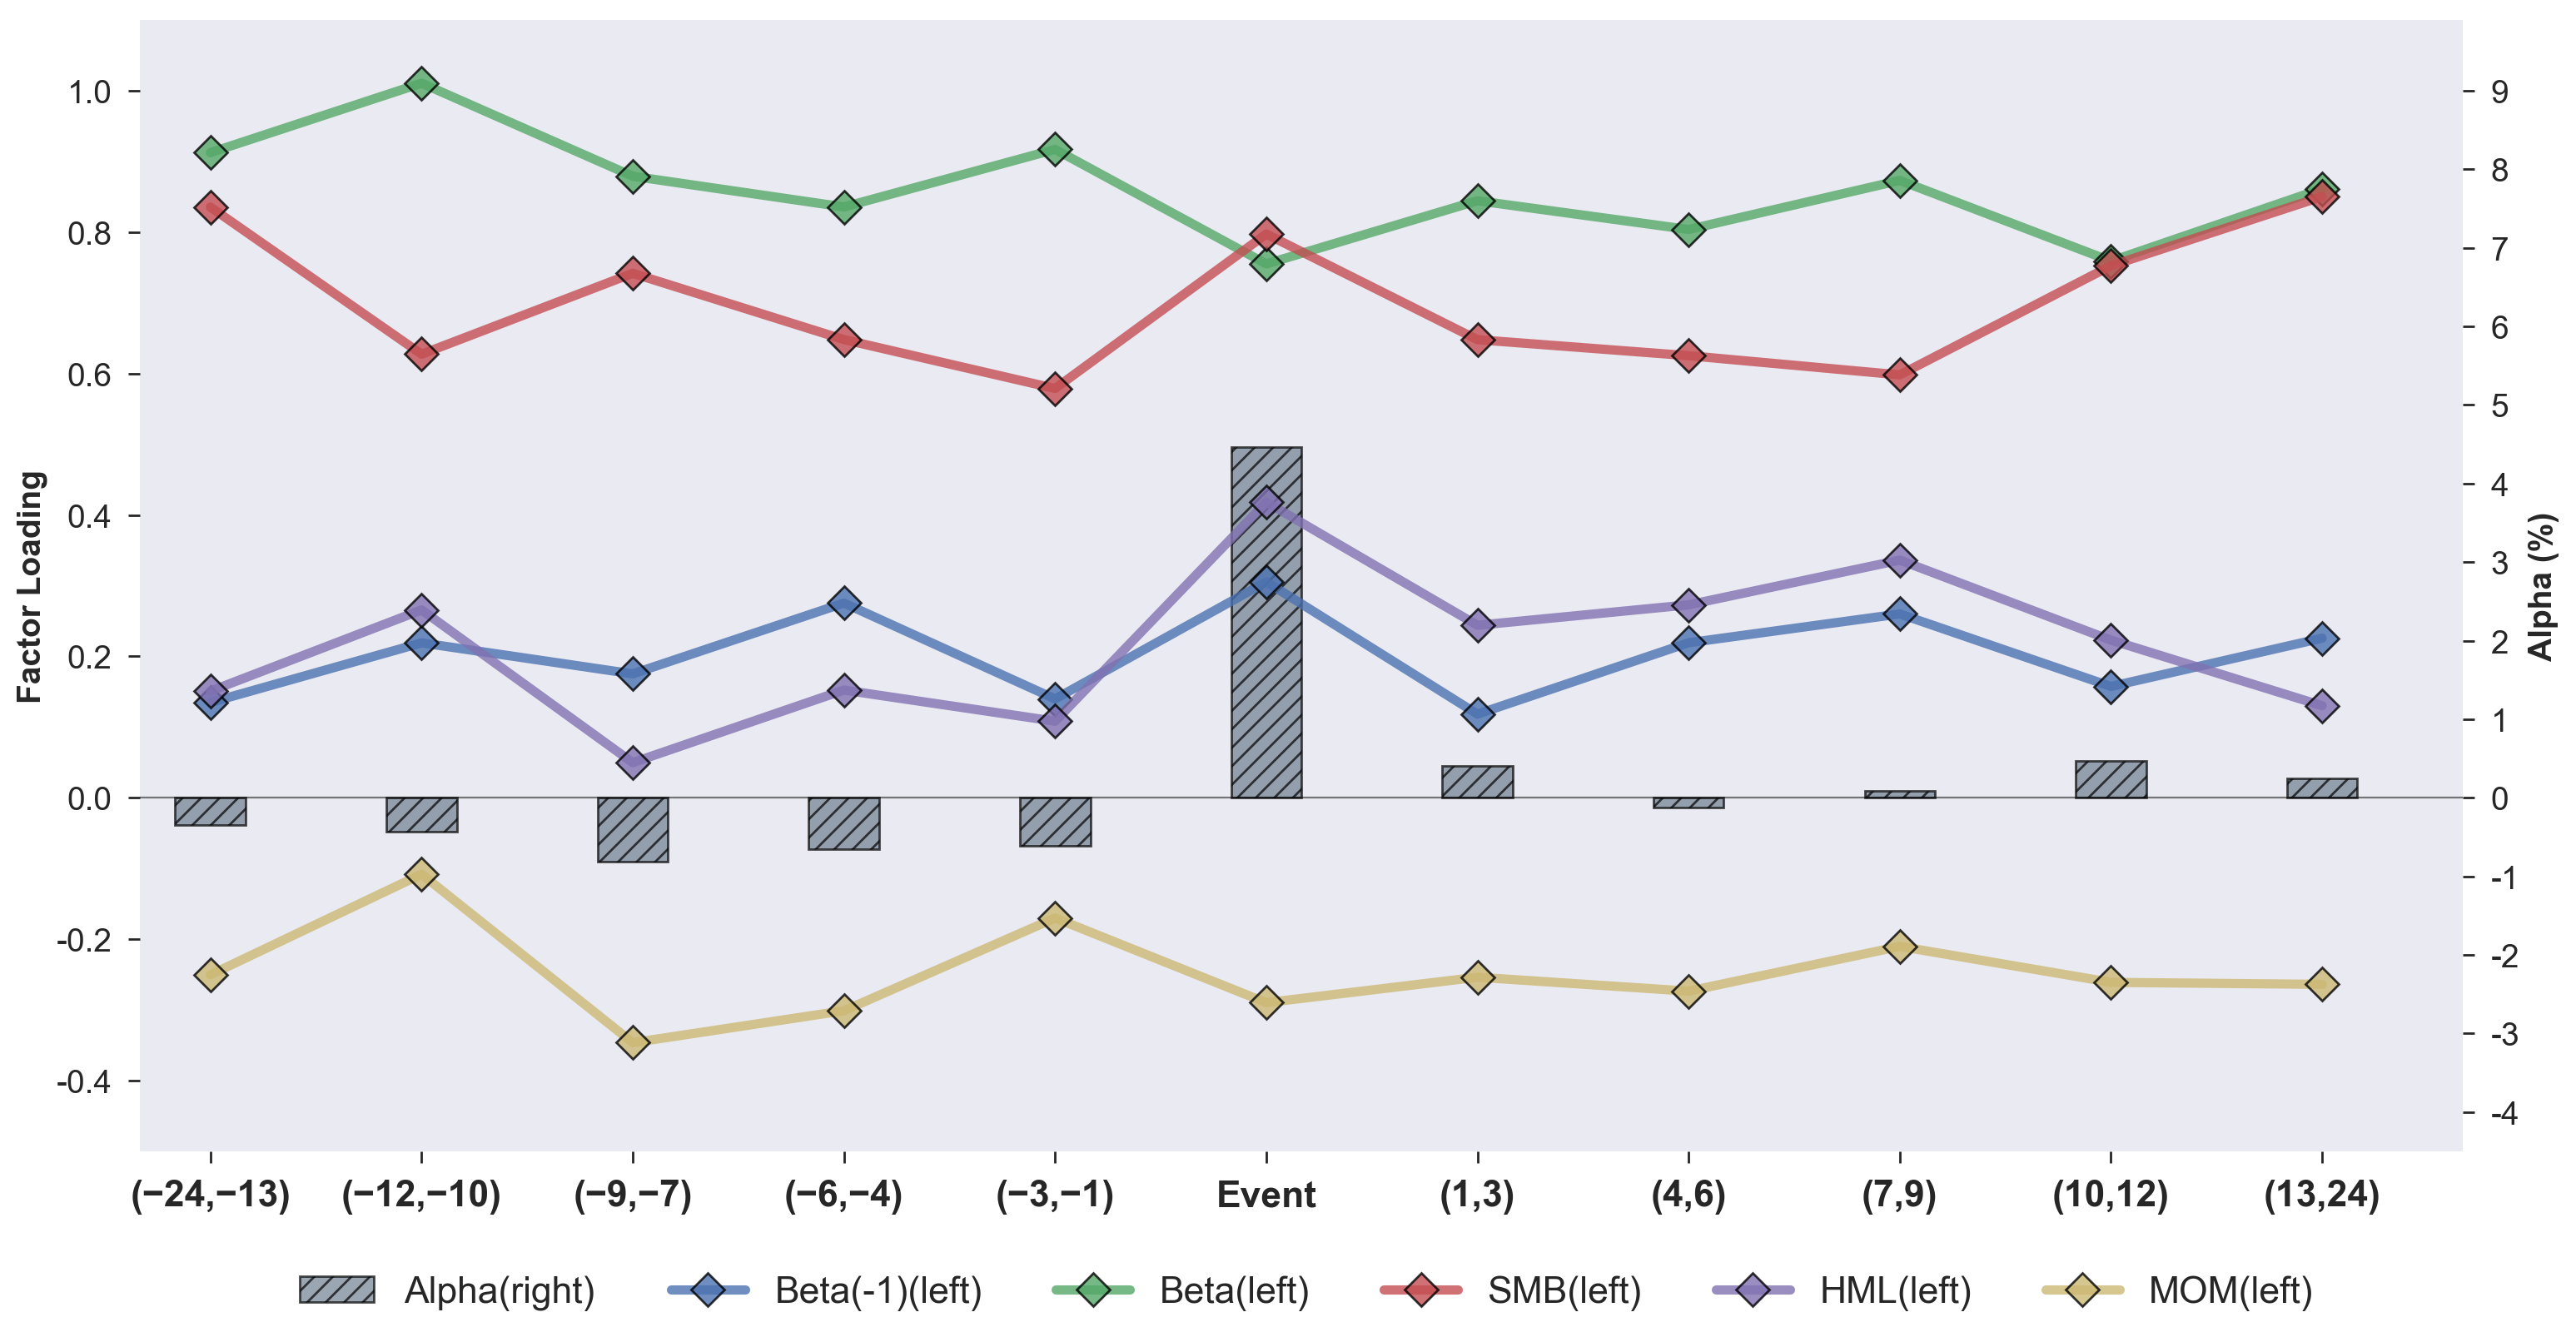

In [32]:
sns.set(style='darkgrid')
fig1 = plt.figure(figsize = (18,9),dpi=200)
ax1 = fig1.add_subplot(111)
ax1.bar(np.arange(0,32,3),coeff_copy.iloc[0,np.arange(0,32,3)].T,width=1,alpha=0.7,
        color='slategrey',\
        edgecolor='black',linewidth=1,hatch='///')
# ax1.plot(np.arange(-1,23,2),np.zeros(12),color='black',lw=0.8,alpha=0.5)
ax1.set_ylim([-4.5,9.9])
ax1.set_xlim([-1,21])
ax1.set_yticks(np.arange(-4,10))
ax1.set_yticklabels(np.round(np.arange(-4,10),1),fontsize=14)
ax1.grid(False)
ax1.tick_params(axis='both',direction='out',length=5,which='both')
# ax1.bar(np.arange(0,21,2),coeff_copy.iloc[0,np.arange(0,21,2)].T,width=1,alpha=0.7,color='slategrey',\
#        edgecolor='black',linewidth=1)
# ax1.plot(coeff2_copy.iloc[0,np.arange(0,21,2)].T,lw = 6,marker = 'D',\
#          markersize=13,markeredgewidth=1,markeredgecolor='black',alpha=1)
ax1.set_ylabel('Alpha (%)',size=14,weight='bold',\
              verticalalignment='bottom')
ax1.legend(['Alpha(right)'],bbox_to_anchor=(0.21,-0.08),fontsize=16)
ax1.plot(np.arange(-1,33,3),np.zeros(12),color='black',lw=0.8,alpha=0.5)
ax2 = ax1.twinx()
ax2.grid(False)
ax2.plot(coeff_copy.iloc[1:,np.arange(0,32,3)].T,lw = 4,marker = 'D',markersize=10,\
         markeredgewidth=1,markeredgecolor='black',\
         alpha=0.8)
ax1.set_xlim([-1,32])
ax1.set_xticks(np.arange(0,32,3))
ax1.set_xticklabels(x_labels,fontsize=16,weight='bold')
ax2.set_ylim([-0.5,1.1])
ax2.set_yticks(np.arange(-0.4,1.2,0.2))
ax2.set_yticklabels(np.round(np.arange(-0.4,1.2,0.2),2),fontsize=14)
ax2.legend(['Beta(-1)(left)','Beta(left)','SMB(left)','HML(left)','MOM(left)'],ncol=5,\
           bbox_to_anchor=(0.95, -0.08),\
#            ,frameon=True,facecolor='white',edgecolor='black',\
          fontsize=16)
ax2.tick_params(axis='both',direction='out',length=5,which='both')
ax2.set_ylabel('Factor Loading',size=14,weight='bold',\
              verticalalignment='bottom')
ax1.yaxis.set_label_position('right')
ax1.yaxis.set_ticks_position('right')
ax2.yaxis.set_label_position('left')
ax2.yaxis.set_ticks_position('left')
plt.savefig("eq_factor.jpg",dpi=200)

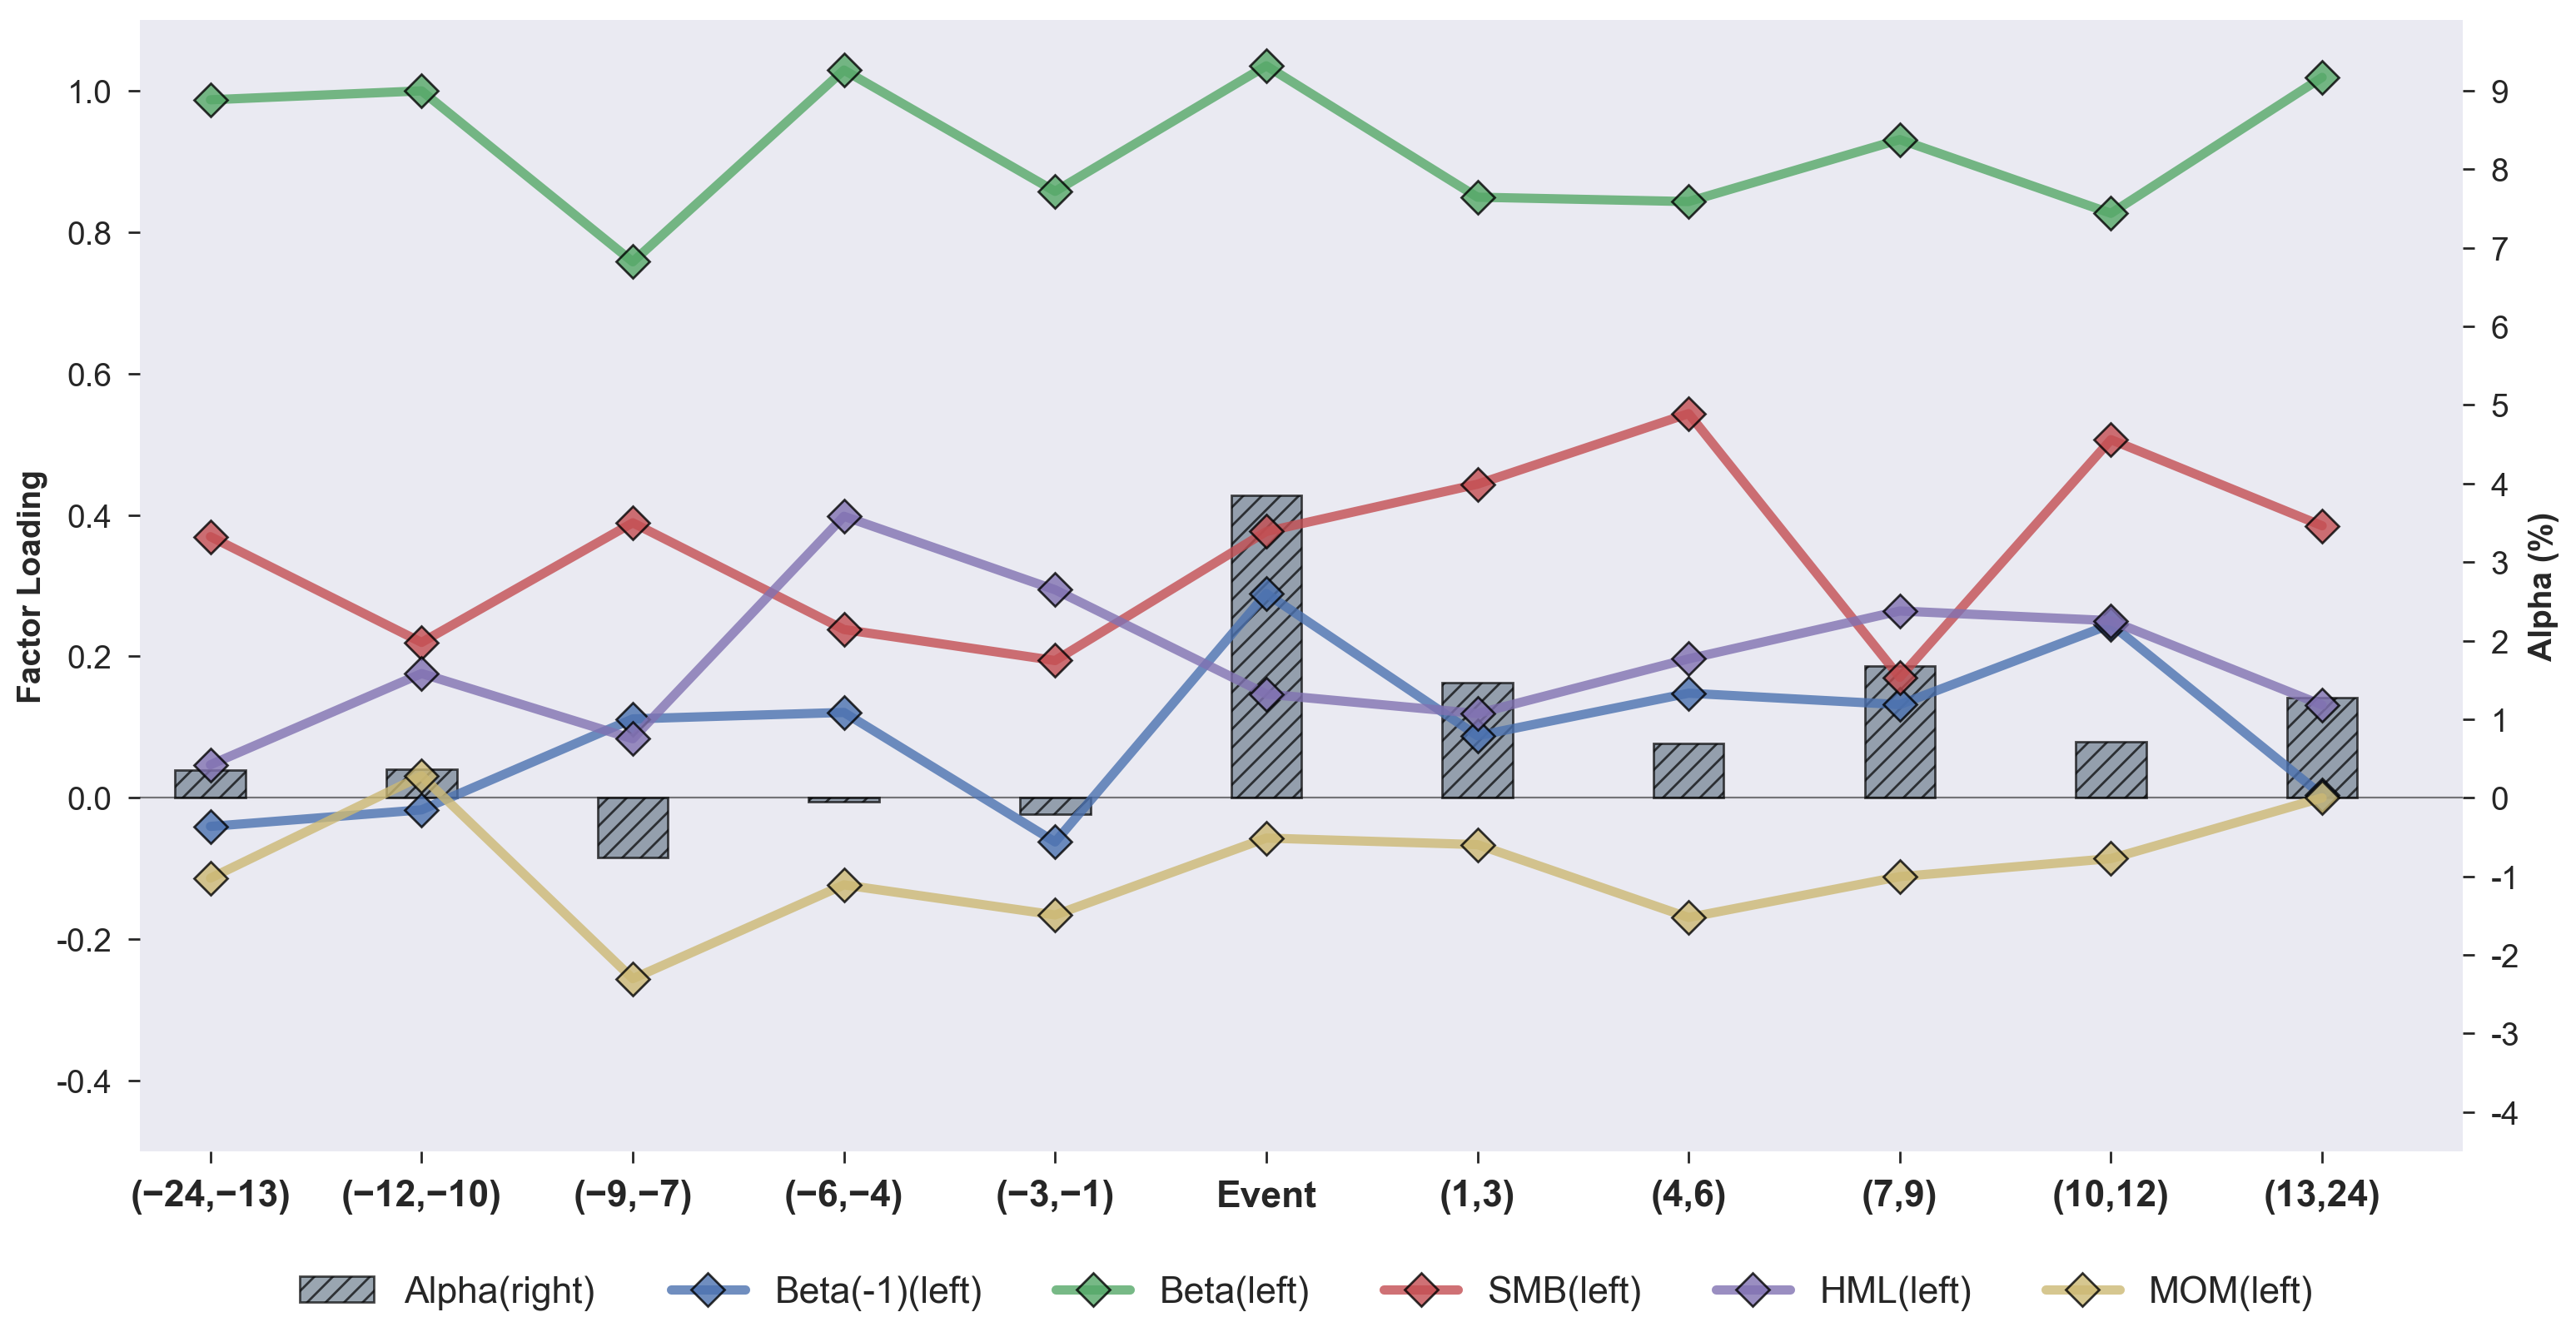

In [34]:
sns.set(style='darkgrid')
fig2 = plt.figure(figsize = (18,9),dpi=200)
ax1 = fig2.add_subplot(111)
ax1.bar(np.arange(0,32,3),coeff2_copy.iloc[0,np.arange(0,32,3)].T,width=1,alpha=0.7,color='slategrey',\
        edgecolor='black',linewidth=1,hatch='///')
# ax1.plot(np.arange(-1,23,2),np.zeros(12),color='black',lw=0.8,alpha=0.5)
ax1.set_ylim([-4.5,9.9])
ax1.set_xlim([-1,21])
ax1.set_yticks(np.arange(-4,10))
ax1.set_yticklabels(np.arange(-4,10),fontsize=14)
ax1.grid(False)
ax1.tick_params(axis='both',direction='out',length=5,which='both')
# ax1.bar(np.arange(0,21,2),coeff_copy.iloc[0,np.arange(0,21,2)].T,width=1,alpha=0.7,color='slategrey',\
#        edgecolor='black',linewidth=1)
# ax1.plot(coeff2_copy.iloc[0,np.arange(0,21,2)].T,lw = 6,marker = 'D',\
#          markersize=13,markeredgewidth=1,markeredgecolor='black',alpha=1)
ax1.set_ylabel('Alpha (%)',size=14,weight='bold',\
              verticalalignment='bottom')
ax1.legend(['Alpha(right)'],bbox_to_anchor=(0.21,-0.08),fontsize=16)
ax1.plot(np.arange(-1,33,3),np.zeros(12),color='black',lw=0.8,alpha=0.5)
ax2 = ax1.twinx()
ax2.grid(False)
ax2.plot(coeff2_copy.iloc[1:,np.arange(0,32,3)].T,lw = 4,marker = 'D',markersize=10,\
         markeredgewidth=1,markeredgecolor='black',\
         alpha=0.8)
ax1.set_xlim([-1,32])
ax1.set_xticks(np.arange(0,32,3))
ax1.set_xticklabels(x_labels,fontsize=16,weight='bold')
ax2.set_ylim([-0.5,1.1])
ax2.set_yticks(np.arange(-0.4,1.2,0.2))
ax2.set_yticklabels(np.round(np.arange(-0.4,1.2,0.2),2),fontsize=14)
ax2.legend(['Beta(-1)(left)','Beta(left)','SMB(left)','HML(left)','MOM(left)'],ncol=5,\
           bbox_to_anchor=(0.95, -0.08),\
#            ,frameon=True,facecolor='white',edgecolor='black',\
          fontsize=16)
ax2.tick_params(axis='both',direction='out',length=5,which='both')
ax2.set_ylabel('Factor Loading',size=14,weight='bold',\
              verticalalignment='bottom')
ax1.yaxis.set_label_position('right')
ax1.yaxis.set_ticks_position('right')
ax2.yaxis.set_label_position('left')
ax2.yaxis.set_ticks_position('left')
plt.savefig("vw_factor.jpg",dpi=400)

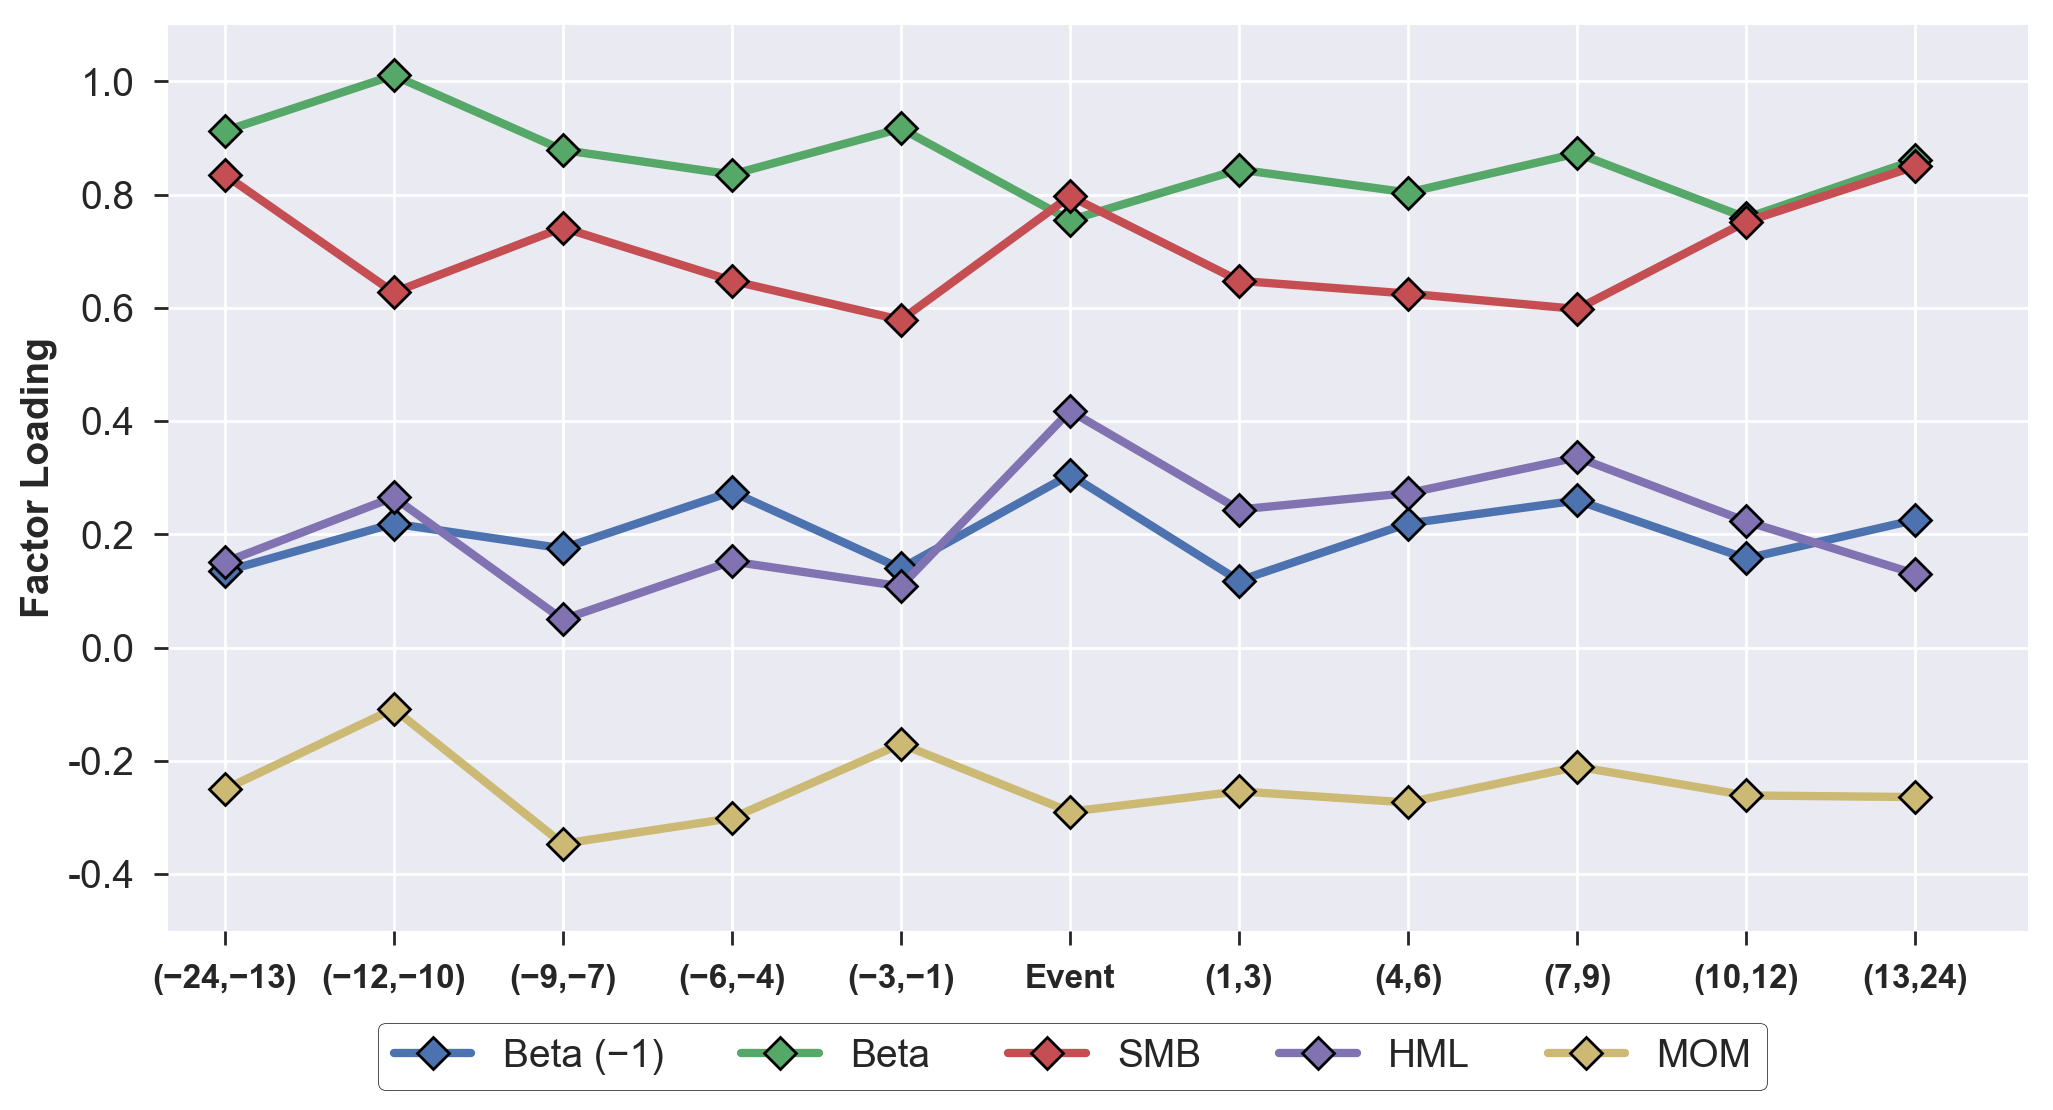

In [54]:
sns.set(style='darkgrid')
fig3 = plt.figure(figsize = (12,6),dpi=200)
ax1 = fig3.add_subplot(111)
ax1.plot(coeff_copy.iloc[1:,np.arange(0,32,3)].T,lw = 3,marker = 'D',markersize=8,\
         markeredgewidth=1,markeredgecolor='black',\
         alpha=1)
ax1.set_xlim([-1,32])
ax1.set_xticks(np.arange(0,32,3))
ax1.set_xticklabels(x_labels,fontsize=12,weight='bold')
ax1.set_ylim([-0.5,1.1])
ax1.set_yticks(np.arange(-0.4,1.2,0.2))
ax1.set_yticklabels(np.round(np.arange(-0.4,1.2,0.2),1),fontsize=14)
ax1.legend(['Beta (−1)','Beta','SMB','HML','MOM'],ncol=5,\
           bbox_to_anchor=(0.87, -0.08),\
           frameon=True,facecolor='white',edgecolor='black',\
           fontsize=14)
ax1.tick_params(axis='both',direction='out',length=5,which='both')
ax1.set_ylabel('Factor Loading',size=14,weight='bold',\
              verticalalignment='bottom')
plt.savefig("eq_factor_loading.png",dpi=200)

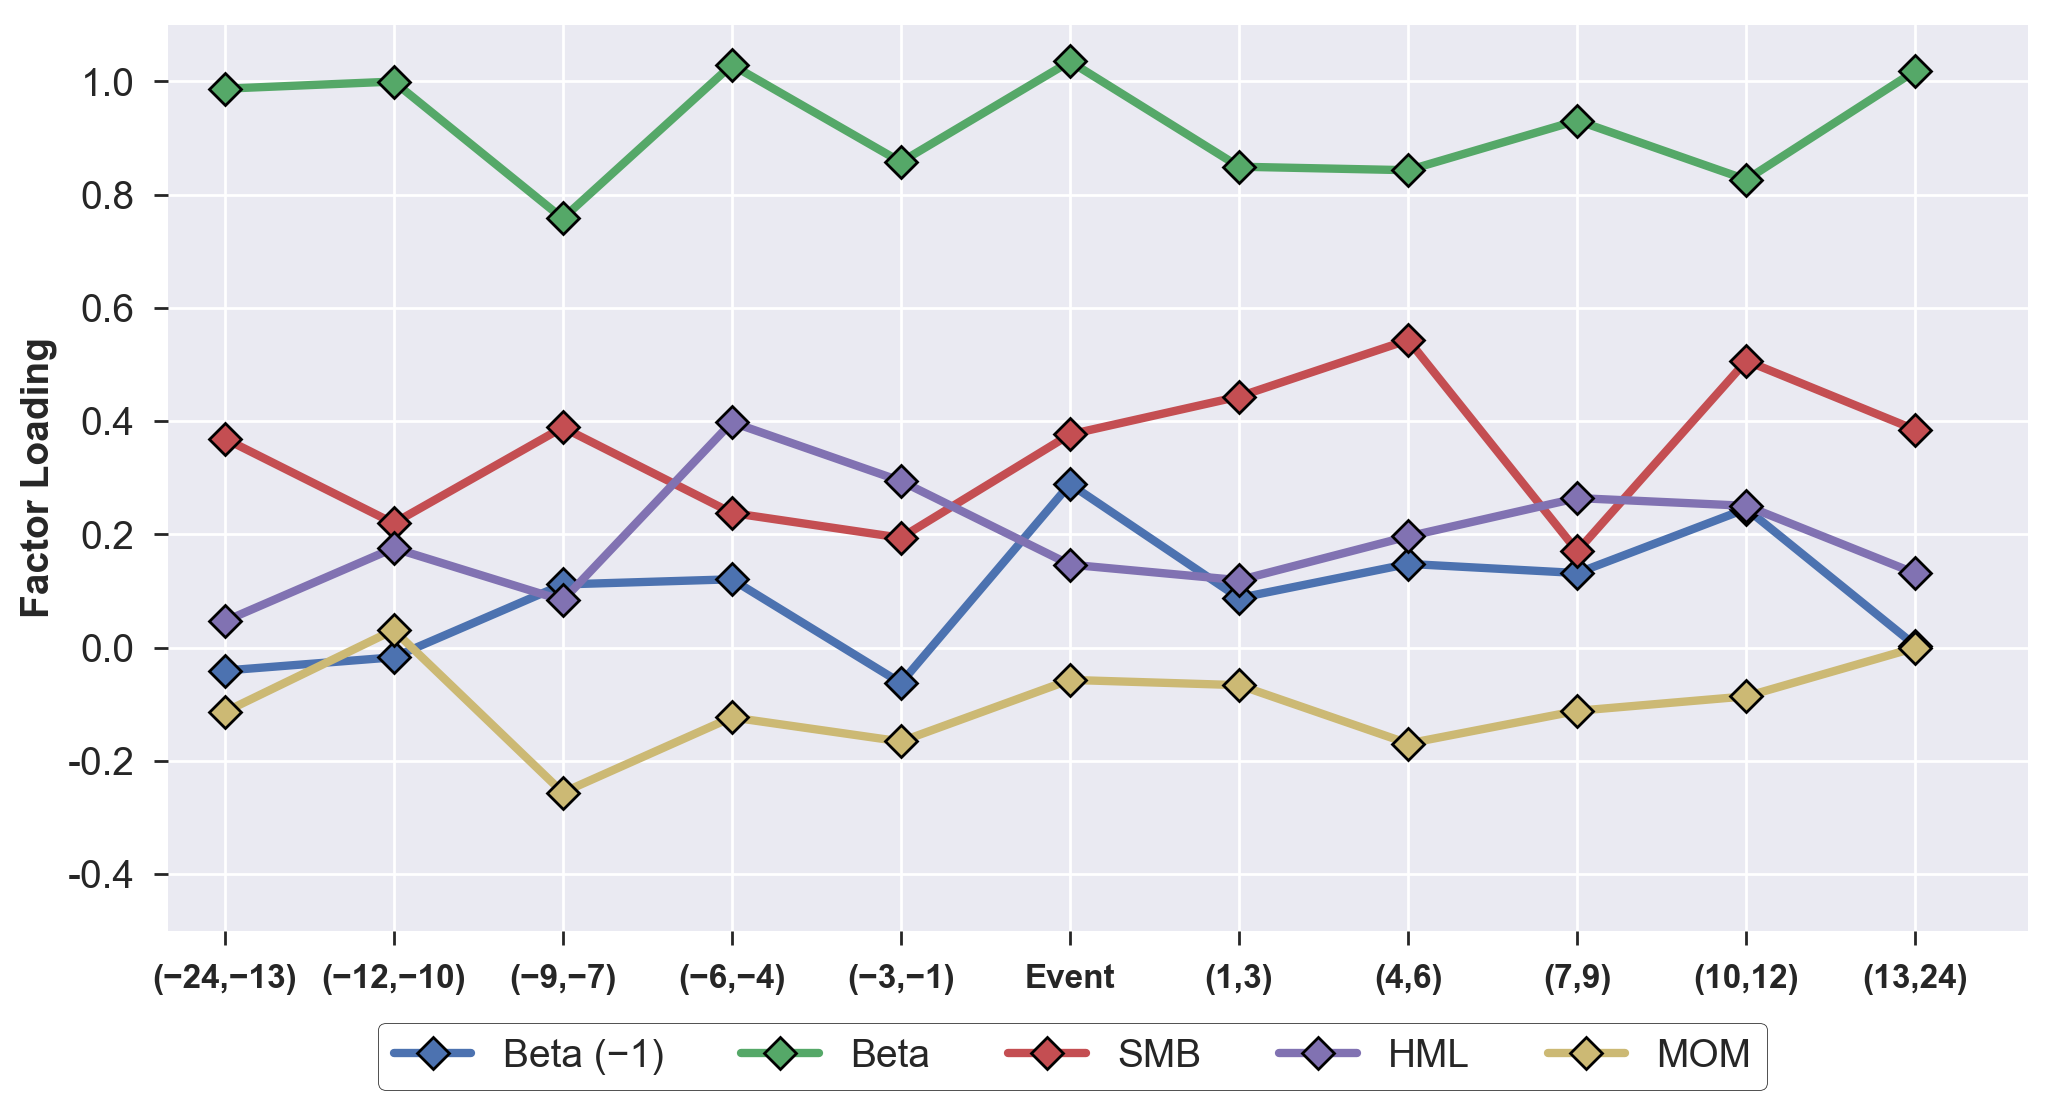

In [55]:
sns.set(style='darkgrid')
fig4 = plt.figure(figsize = (12,6),dpi=200)
ax1 = fig4.add_subplot(111)
ax1.plot(coeff2_copy.iloc[1:,np.arange(0,32,3)].T,lw = 3,marker = 'D',markersize=8,\
         markeredgewidth=1,markeredgecolor='black',\
         alpha=1)
ax1.set_xlim([-1,32])
ax1.set_xticks(np.arange(0,32,3))
ax1.set_xticklabels(x_labels,fontsize=12,weight='bold')
ax1.set_ylim([-0.5,1.1])
ax1.set_yticks(np.arange(-0.4,1.2,0.2))
ax1.set_yticklabels(np.round(np.arange(-0.4,1.2,0.2),1),fontsize=14)
ax1.legend(['Beta (−1)','Beta','SMB','HML','MOM'],ncol=5,\
           bbox_to_anchor=(0.87, -0.08),\
           frameon=True,facecolor='white',edgecolor='black',\
           fontsize=14)
ax1.tick_params(axis='both',direction='out',length=5,which='both')
ax1.set_ylabel('Factor Loading',size=14,weight='bold',\
              verticalalignment='bottom')
plt.savefig("vw_factor_loading.jpg",dpi=400)

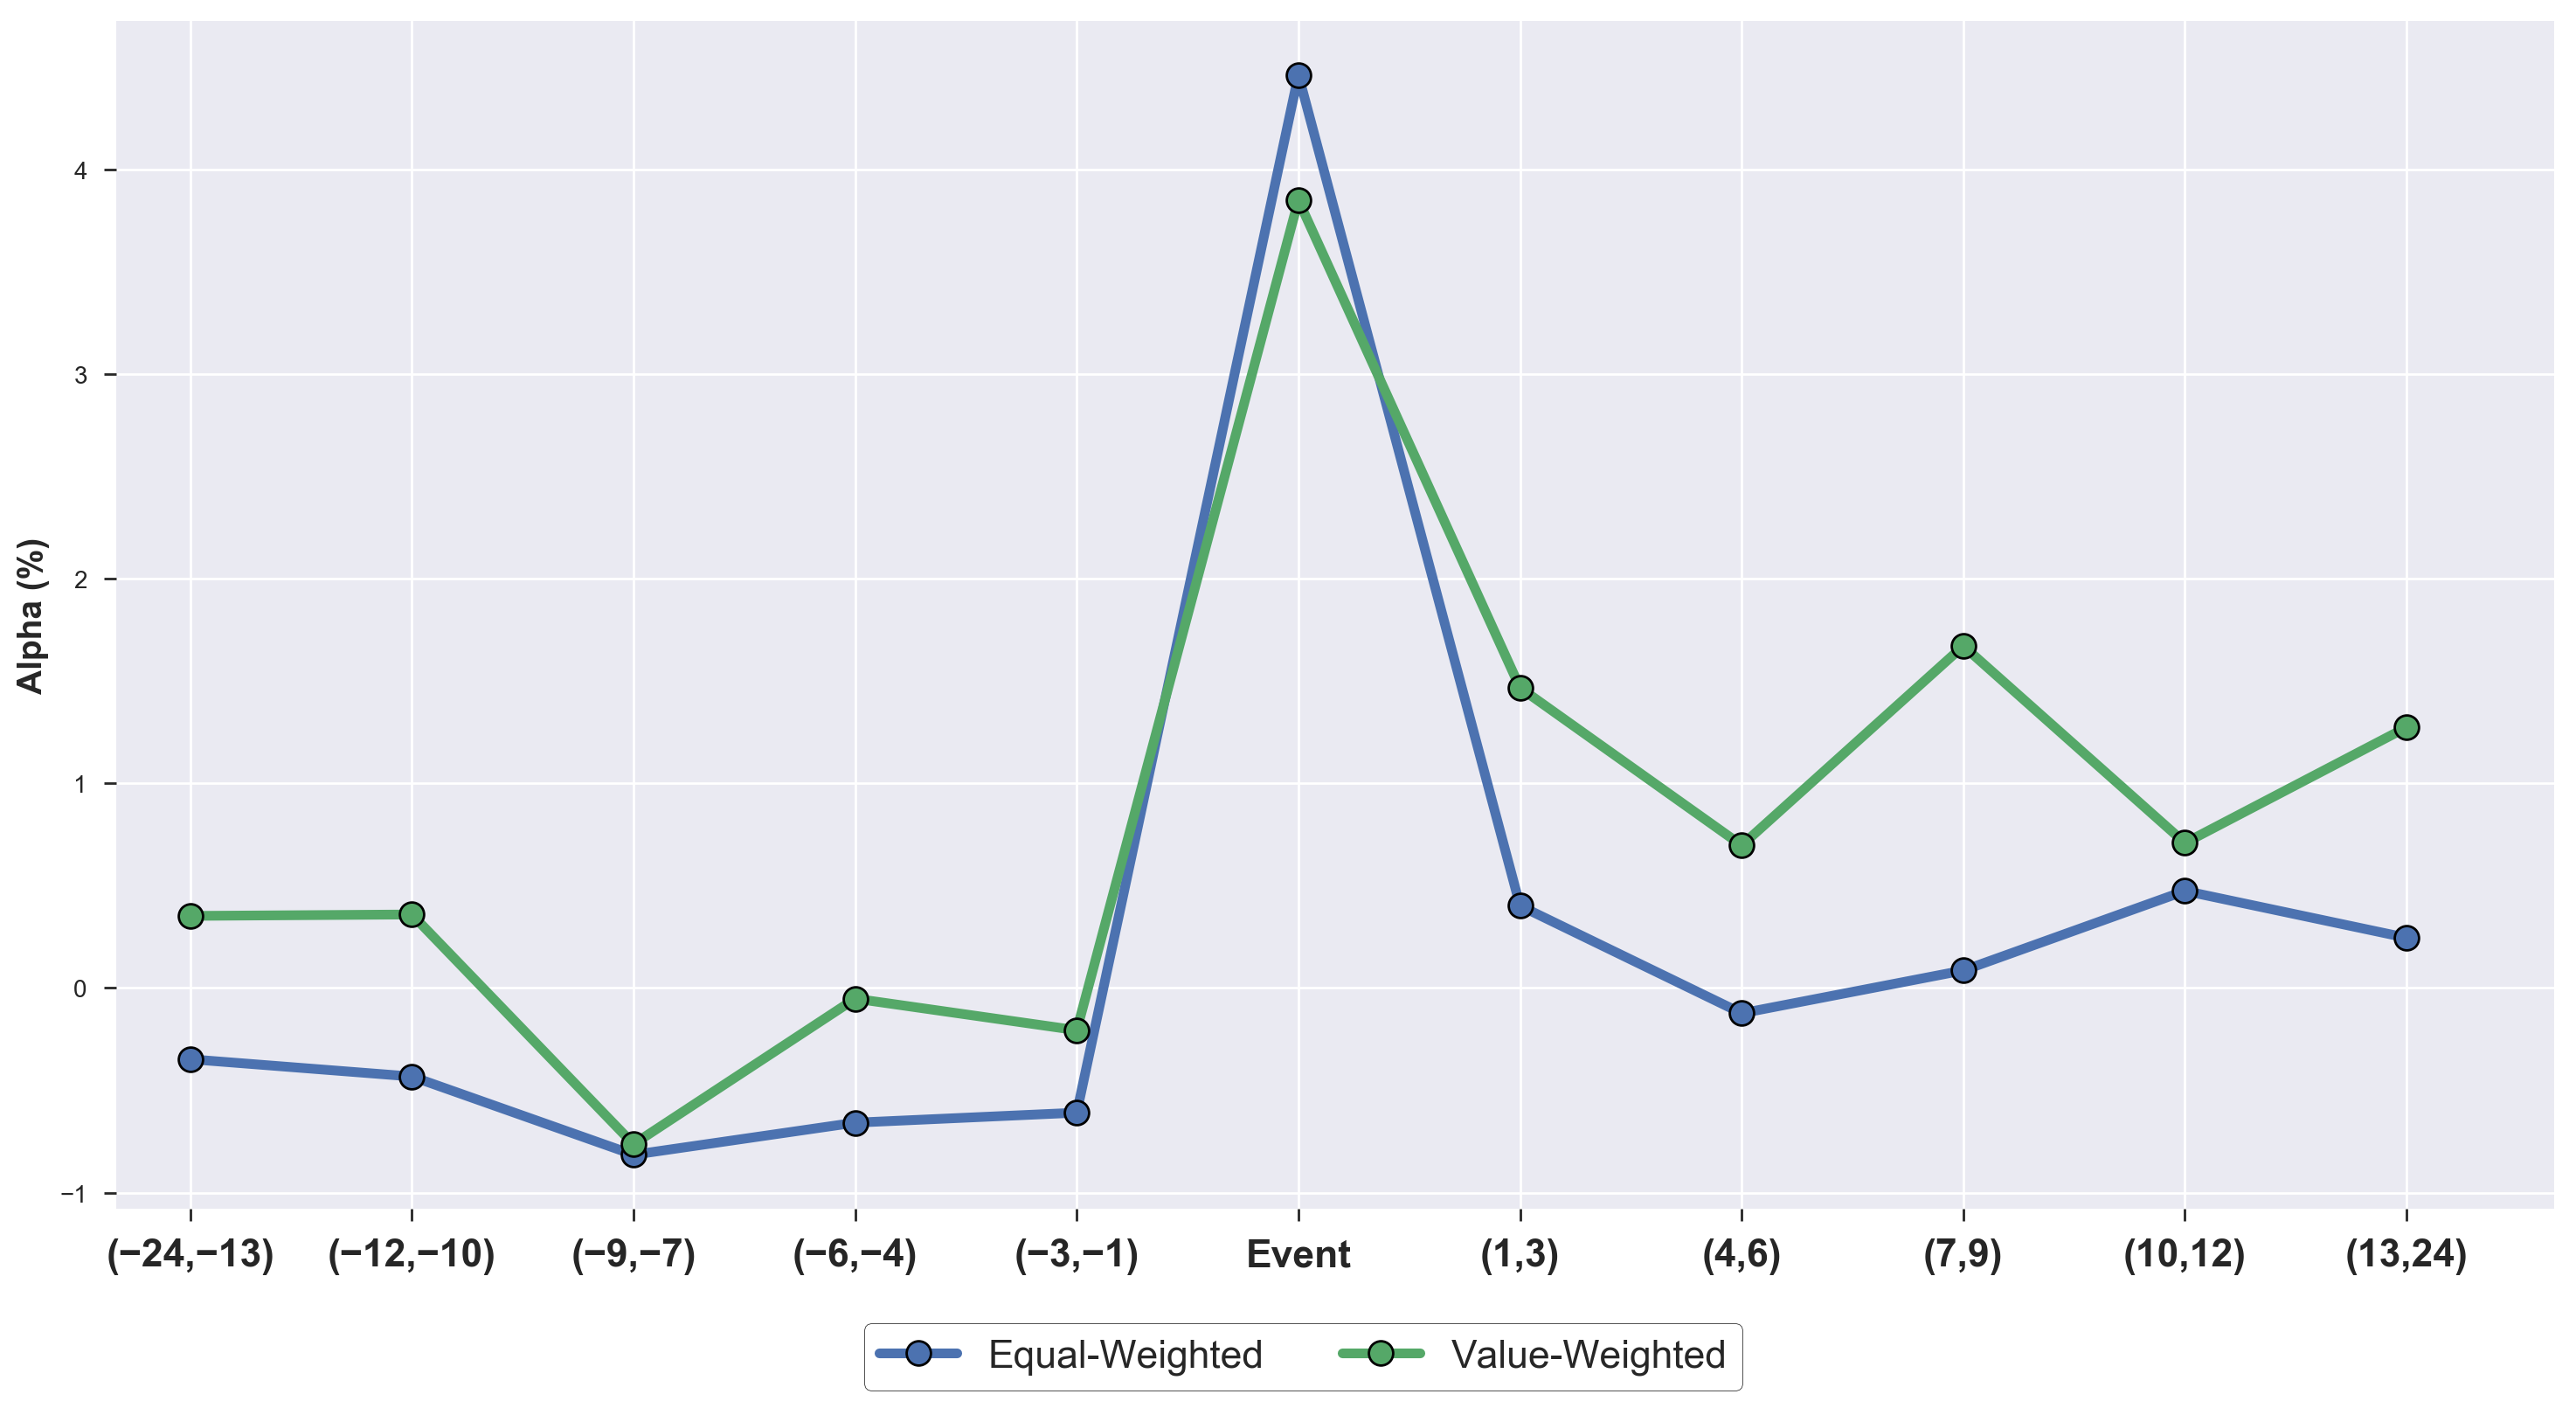

In [38]:
sns.set(style='darkgrid')
fig5 = plt.figure(figsize = (18,9),dpi=200)
ax1 = fig5.add_subplot(111)
ax1.plot(coeff_copy.iloc[0,np.arange(0,32,3)].T,lw = 4,marker = 'o',markersize=10,\
         markeredgewidth=1,markeredgecolor='black',\
         alpha=1)
ax1.plot(coeff2_copy.iloc[0,np.arange(0,32,3)].T,lw = 4,marker = 'o',markersize=10,\
         markeredgewidth=1,markeredgecolor='black',\
         alpha=1)
ax1.set_xlim([-1,32])
ax1.set_xticks(np.arange(0,32,3))
ax1.set_xticklabels(x_labels,fontsize=16,weight='bold')
# ax1.set_ylim([-0.5,1.1])
# ax1.set_yticks(np.arange(-0.4,1.2,0.2))
# ax1.set_yticklabels(np.arange(-0.4,1.2,0.2),fontsize=14)
ax1.legend(['Equal-Weighted','Value-Weighted'],ncol=2,\
           bbox_to_anchor=(0.675, -0.08),\
           frameon=True,facecolor='white',edgecolor='black',\
           fontsize=16)
ax1.tick_params(axis='both',direction='out',length=5,which='both')
ax1.set_ylabel('Alpha (%)',size=14,weight='bold',\
              verticalalignment='bottom')
plt.savefig("alpha1.jpg",dpi=400)

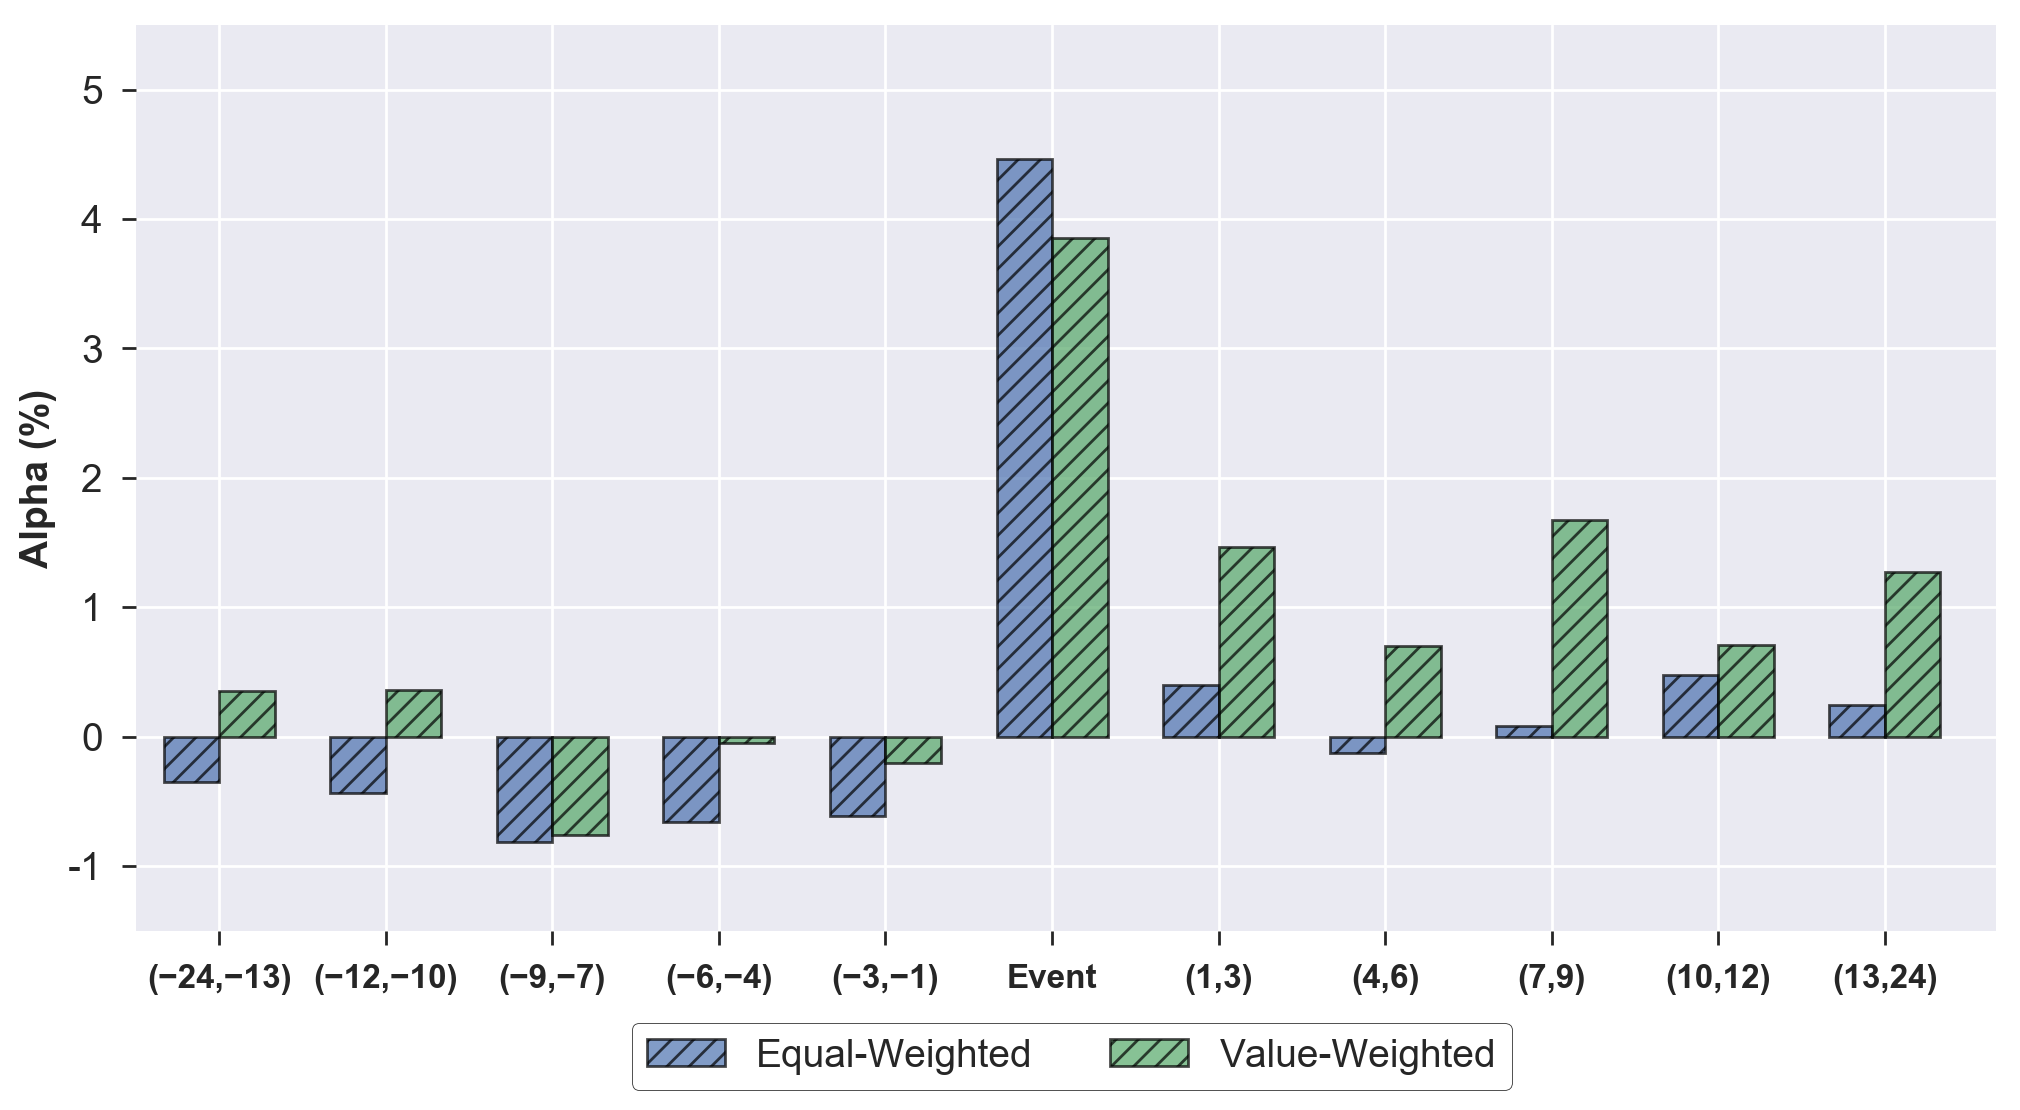

In [76]:
sns.set(style='darkgrid')
fig6 = plt.figure(figsize = (12,6),dpi=200)
ax1 = fig6.add_subplot(111)
ax1.bar(np.arange(-0.5,32,3),coeff_copy.iloc[0,np.arange(0,32,3)].T,width=1,alpha=0.7,\
        edgecolor='black',linewidth=1,hatch='///')
ax1.bar(np.arange(-0.5,32,3)+1,coeff2_copy.iloc[0,np.arange(0,32,3)].T,width=1,alpha=0.7,\
        edgecolor='black',linewidth=1,hatch='///')
ax1.set_xlim([-1.5,32])
ax1.set_xticks(np.arange(0,32,3))
ax1.set_xticklabels(x_labels,fontsize=12,weight='bold')
ax1.set_ylim([-1.5,5.5])
ax1.set_yticks(np.arange(-1,6,1))
ax1.set_yticklabels(np.arange(-1,6,1),fontsize=14)
ax1.legend(['Equal-Weighted','Value-Weighted'],ncol=2,\
           bbox_to_anchor=(0.75, -0.08),\
           frameon=True,facecolor='white',edgecolor='black',\
           fontsize=14)
ax1.tick_params(axis='both',direction='out',length=5,which='both')
ax1.set_ylabel('Alpha (%)',size=14,weight='bold',\
              verticalalignment='bottom')
plt.savefig("alpha2.png",dpi=200,bbox_inches='tight')

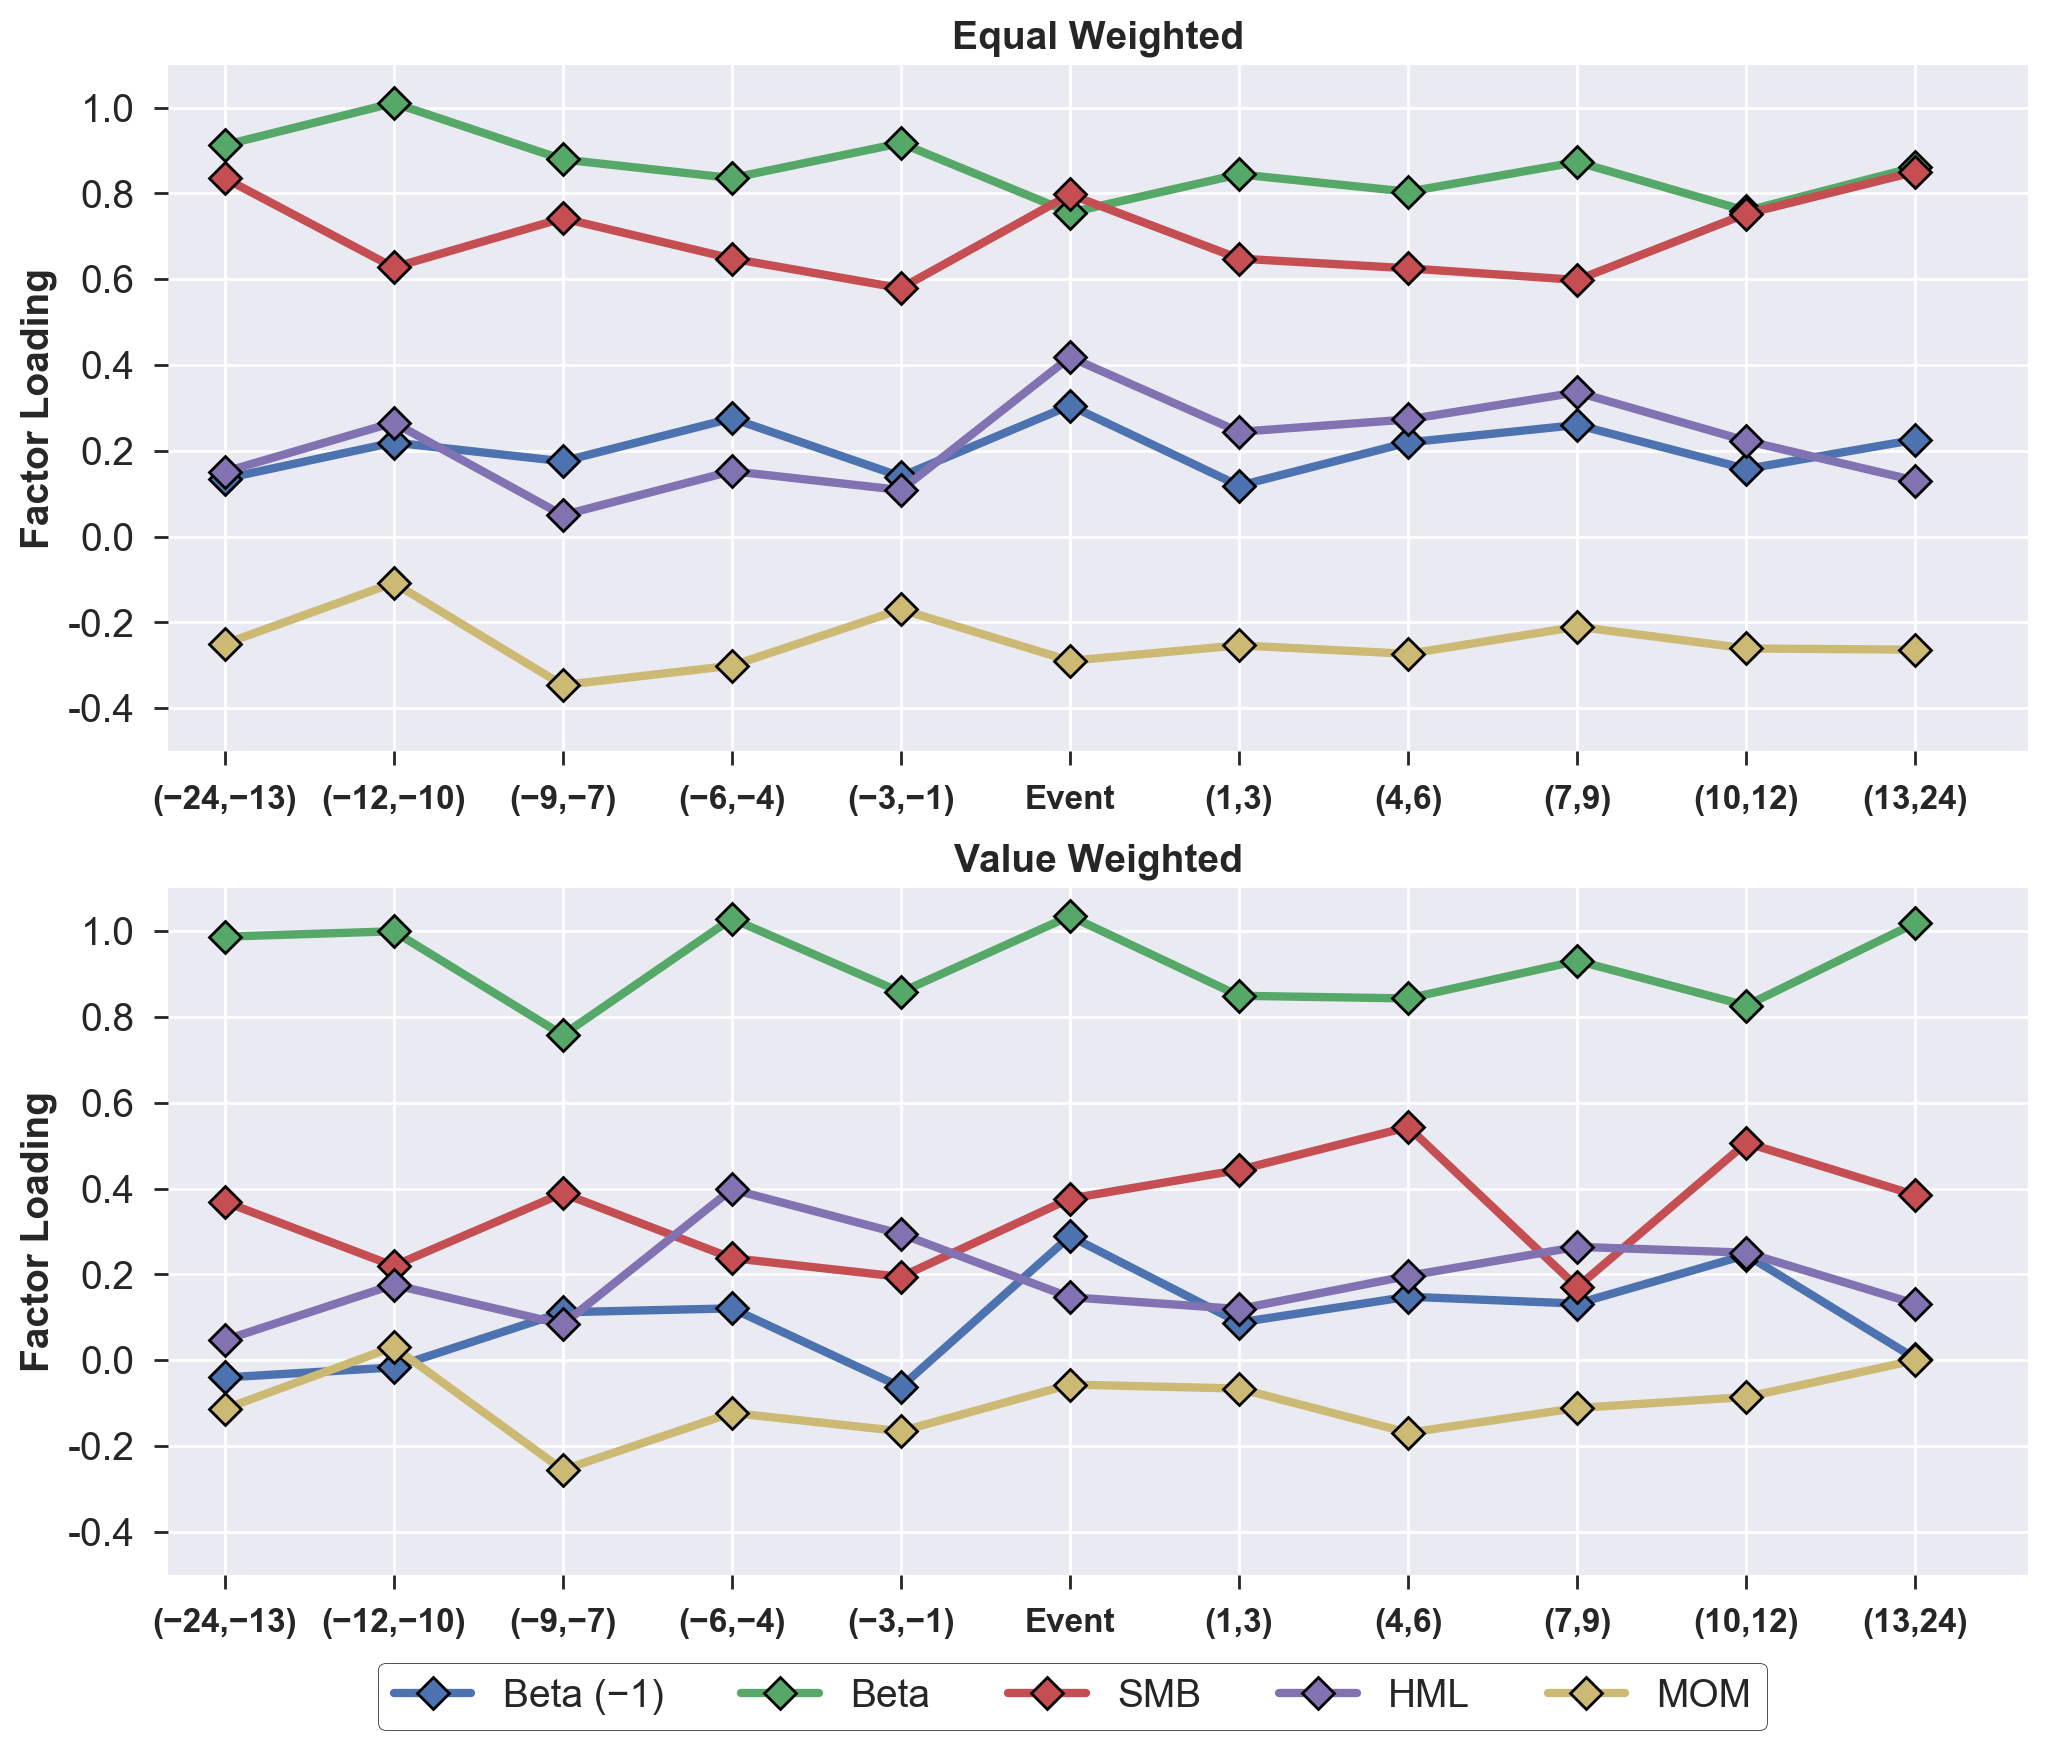

In [75]:
sns.set(style='darkgrid')
fig3 = plt.figure(figsize = (12,10),dpi=200)
fig3.subplots_adjust(hspace=0.2)
ax1 = fig3.add_subplot(211)
ax1.set_title('Equal Weighted',size=14,weight='bold')
ax1.plot(coeff_copy.iloc[1:,np.arange(0,32,3)].T,lw = 3,marker = 'D',markersize=8,\
         markeredgewidth=1,markeredgecolor='black',\
         alpha=1)
ax1.set_xlim([-1,32])
ax1.set_xticks(np.arange(0,32,3))
ax1.set_xticklabels(x_labels,fontsize=12,weight='bold')
ax1.set_ylim([-0.5,1.1])
ax1.set_yticks(np.arange(-0.4,1.2,0.2))
ax1.set_yticklabels(np.round(np.arange(-0.4,1.2,0.2),1),fontsize=14)
# ax1.legend(['Beta (−1)','Beta','SMB','HML','MOM'],ncol=5,\
#            bbox_to_anchor=(0.87, -0.08),\
#            frameon=True,facecolor='white',edgecolor='black',\
#            fontsize=14)
ax1.tick_params(axis='both',direction='out',length=5,which='both')
ax1.set_ylabel('Factor Loading',size=14,weight='bold',\
              verticalalignment='bottom')


ax3 = fig3.add_subplot(212)
ax3.set_title('Value Weighted',size=14,weight='bold')
ax3.plot(coeff2_copy.iloc[1:,np.arange(0,32,3)].T,lw = 3,marker = 'D',markersize=8,\
         markeredgewidth=1,markeredgecolor='black',\
         alpha=1)
ax3.set_xlim([-1,32])
ax3.set_xticks(np.arange(0,32,3))
ax3.set_xticklabels(x_labels,fontsize=12,weight='bold')
ax3.set_ylim([-0.5,1.1])
ax3.set_yticks(np.arange(-0.4,1.2,0.2))
ax3.set_yticklabels(np.round(np.arange(-0.4,1.2,0.2),1),fontsize=14)
ax3.legend(['Beta (−1)','Beta','SMB','HML','MOM'],ncol=5,\
           bbox_to_anchor=(0.87, -0.1),\
           frameon=True,facecolor='white',edgecolor='black',\
           fontsize=14)
ax3.tick_params(axis='both',direction='out',length=5,which='both')
ax3.set_ylabel('Factor Loading',size=14,weight='bold',\
              verticalalignment='bottom')
plt.savefig("factor_loading.png",dpi=200,bbox_inches='tight')